In [5]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, in_context_from_samples, test_prompt_from_samples, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_lenpar_more_and_context"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 67,
 'all_upper': 59,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'start_cap': 133,
 'start_lower': 67,
 'start_the': 57}


In [3]:
# datasets: all upper vs lower; starts with a capital vs not; has a capital vs not
# even vs odd counts; even vs odd length w/ all upper vs lower-->even mixed, odd mixed
# fragments vs sentence; just subject/verb fragments vs all
# nature vs rest
# contains a proper noun
tags_true = ["even_words"]
tags_false = ["odd_words"]
tags_common = ["sentence"]
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common)

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

In [4]:
pprint(sorted(positives, key=lambda x: "all_upper" not in x["tags"]))

[{'input': 'SCIENCE AND TECHNOLOGY ARE DRIVING INNOVATION.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'even_words',
           'gpt4']},
 {'input': 'READING OPENS DOORS TO NEW WORLDS.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'even_words',
           'gpt4']},
 {'input': 'THE MOONLIGHT CASTS A GLOW OVER THE NIGHT.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'nature',
           'even_words',
           'start_the',
           'gpt4']},
 {'input': 'THE ONLY LIMIT TO OUR REALIZATION OF TOMORROW WILL BE OUR DOUBTS '
           'OF TODAY.',
  'label': True,
  'tags': ['start_the',
           'start_cap',
           'all_upper',
           'sentence',
           'even_words',
           'gpt4']},
 {'input': 'MUSIC HAS THE POWER TO EVOKE 

In [5]:
pprint(negatives)

[{'input': 'THE OLYMPICS CELEBRATE ATHLETIC EXCELLENCE.',
  'label': False,
  'tags': ['start_the',
           'start_cap',
           'all_upper',
           'sentence',
           'odd_words',
           'gpt4',
           'proper_noun']},
 {'input': 'The aroma of freshly baked cookies fills the kitchen.',
  'label': False,
  'tags': ['start_the', 'start_cap', 'sentence', 'odd_words', 'gpt4']},
 {'input': 'Early mornings are a time of reflection.',
  'label': False,
  'tags': ['odd_words', 'start_cap', 'sentence', 'gpt4']},
 {'input': "LIFE IS WHAT HAPPENS WHEN YOU'RE BUSY MAKING PLANS.",
  'label': False,
  'tags': ['start_cap', 'all_upper', 'sentence', 'odd_words', 'gpt4']},
 {'input': 'the world is full of fascinating cultures.',
  'label': False,
  'tags': ['start_the',
           'all_lower',
           'sentence',
           'odd_words',
           'start_lower',
           'gpt4']},
 {'input': 'Laughter is a universal language.',
  'label': False,
  'tags': ['odd_words', 'star

In [6]:
samples_per_label = 10
num_test_samples = 50

prompt_prefix = """
Below is a set of examples from a string classification dataset. Users will give you new inputs and you will need to classify
them based on these samples. The true labels are determined using a simple classification rule that can easily be articulated
in plain English.
"""

in_context_samples = positives[:samples_per_label] + negatives[:samples_per_label]
in_context_prompt = in_context_from_samples(in_context_samples, prompt_prefix=prompt_prefix)
with open(output_dir / "in_context_prompt.txt", "w") as f:
    f.write(in_context_prompt)

test_positives = positives[samples_per_label:][:num_test_samples]
test_negatives = negatives[samples_per_label:][:num_test_samples]
test_prompt, test_samples = test_prompt_from_samples(test_positives, test_negatives)
with open(output_dir / "test_prompt.txt", "w") as f:
    f.write(test_prompt)
json.dump(test_samples, open(output_dir / "test_samples.json", "w"), indent=2)

In [8]:
temperatures = [0, 0.5, 1, 1.25, 1.5]
# temperatures = [1]
response_jsons = []
in_context_prompt = open(output_dir / "in_context_prompt.txt").read()
test_prompt = open(output_dir / "test_prompt.txt").read()
test_samples = json.load(open(output_dir / "test_samples.json"))
for t in temperatures:
    response_json = gpt_prediction(in_context_prompt, test_prompt, temperature=t, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{t}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:85: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:86: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:89: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:90: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")


In [6]:
temperatures = [0, 0.5, 1, 1.25, 1.5]
# temperatures = [1]
response_jsons = [json.load(open(output_dir / f"response_{t}.json")) for t in temperatures]
test_samples = json.load(open(output_dir / "test_samples.json"))

results = []
responses = []
for r in response_jsons:
    response, result = eval_response(r, test_samples)
    results.append(result)
    responses.append(response)

In [7]:
for t, r in zip(temperatures, results):
    r["temp"] = t
pprint(results)

[{'accuracy': 0.49,
  'correct': 49,
  'corrupted': 0,
  'incorrect': 51,
  'mismatch': 0,
  'temp': 0,
  'total': 100},
 {'accuracy': 0.6,
  'correct': 60,
  'corrupted': 0,
  'incorrect': 40,
  'mismatch': 0,
  'temp': 0.5,
  'total': 100},
 {'accuracy': 0.45,
  'correct': 45,
  'corrupted': 0,
  'incorrect': 55,
  'mismatch': 0,
  'temp': 1,
  'total': 100},
 {'accuracy': 0.48,
  'correct': 48,
  'corrupted': 0,
  'incorrect': 52,
  'mismatch': 0,
  'temp': 1.25,
  'total': 100},
 {'accuracy': 0.47,
  'correct': 47,
  'corrupted': 0,
  'incorrect': 53,
  'mismatch': 0,
  'temp': 1.5,
  'total': 100}]


In [8]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

      correct  mismatch  incorrect  corrupted
temp                                         
0.00     0.49       0.0       0.51        0.0
0.50     0.60       0.0       0.40        0.0
1.00     0.45       0.0       0.55        0.0
1.25     0.48       0.0       0.52        0.0
1.50     0.47       0.0       0.53        0.0


Text(0.5, 1.0, 'Sentence Length Parity (n=100, pos=50, neg=50; )')

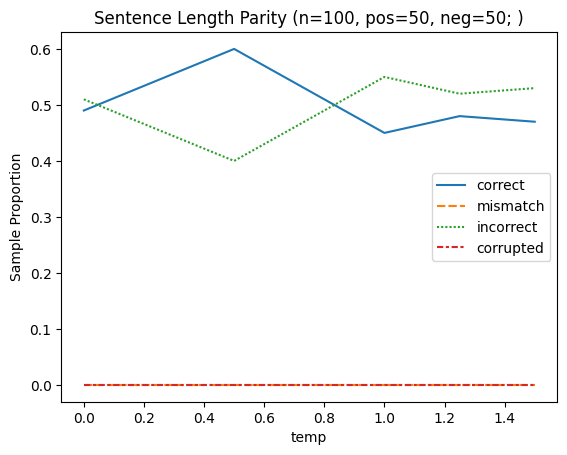

In [9]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

test_samples = json.load(open(output_dir / "test_samples.json"))
total_samples = len(test_samples)
pos_samples = len([s for s in test_samples if s["label"]])
neg_samples = total_samples - pos_samples

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)

for col in df.columns:
    df[col] /= df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("temp", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Sentence Length Parity (n={total_samples}, pos={pos_samples}, neg={neg_samples}; )")